# Traveltime computation with Eikonal equation

Eikonal equation is an equation that....


code is inspired by https://github.com/malcolmw/pykonal

In [72]:
from __future__ import division
import heapq as hq
import numpy as np

import skimage.filters
import skimage.io

import matplotlib.pyplot as plt

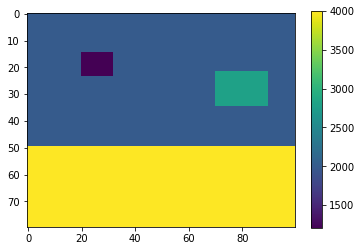

In [73]:
h = dx = dz = 1 #meters

#Size of model in meters
nx = 100
nz = 80


vp = 2000.0     #m/s
vmodel = vp * np.ones((nx, nz), dtype = float)

vmodel[:, 50:] = vp*2
vmodel[70:90, 22:35] = vp*1.4
vmodel[20:32, 15:24] = vp*0.6


im_v = plt.imshow(vmodel.T)
plt.colorbar()
plt.show()

In [74]:
sou_x = 40
sou_z = 0

In [75]:
t_final = np.ones_like(vmodel)*float(np.inf)
t_is_ready = np.zeros_like(vmodel, dtype = bool)

t_final[sou_x, sou_z] = 0
t_is_ready[sou_x, sou_z] = True

front_points = []
hq.heapify(front_points)

hq.heappush(front_points, (0, (sou_x, sou_z)))

In [76]:
while len(front_points) > 0:
    ti, (xi, zi) = hq.heappop(front_points) # returns time and (x,z) of a point with lowest time
    vi = vmodel[xi, zi]
    neighbors = [(xi+1, zi), (xi-1, zi), (xi, zi-1), (xi, zi+1)]
    
    for (xn, zn) in neighbors:
        if (not (0 < xn < nx-1 and  0 < zn < nz-1) or t_is_ready[xn, zn]): #check that point is inside model
            continue
        t_hor = np.min((t_final[xn-1, zn], t_final[xn+1, zn]))
        t_ver = np.min((t_final[xn, zn-1], t_final[xn, zn-1]))
        
        if (abs(t_hor - t_ver) <= h/vi):
            t_final[xn, zn] = 0.5*(t_ver + t_hor + np.sqrt((t_hor+t_ver)**2 -2*(t_hor**2 + t_ver**2 - (h/vi)**2 )))
        else:
            t_final[xn, zn] = np.min((t_hor, t_ver)) + h/vi
        
        indices = [f[1] for f in front_points]
        
        if (xn, zn) in indices:
            front_points[indices.index((xn,zn))] = (t_final[xn,zn], (xn, zn))
        else:
            hq.heappush(front_points, (t_final[xn,zn], (xn, zn)))

    t_is_ready[xi, zi] = True
    front_points.sort()

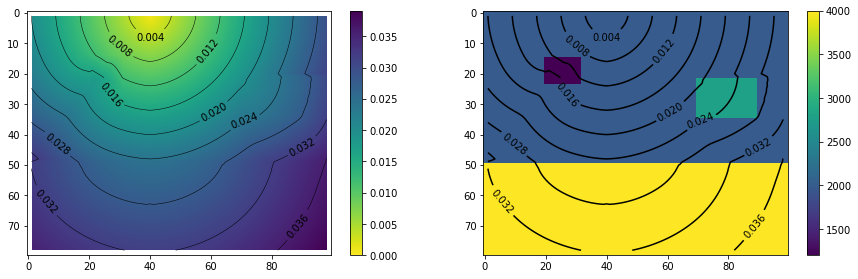

In [77]:
f, [ax1, ax2] = plt.subplots(1,2, figsize=[15,4.5])
im1 = ax1.imshow(t_final.T, interpolation='bilinear', cmap = 'viridis_r')
cs = ax1.contour(t_final.T, 10, colors = 'k', linewidths = 0.5)
ax1.clabel(cs, inline=1, fontsize=10)

im2 = ax2.imshow(vmodel.T, cmap = 'viridis')
cs = ax2.contour(t_final.T, 10, colors = 'k')
ax2.clabel(cs, inline=1, fontsize=10)

f.colorbar(im1, ax = ax1)
f.colorbar(im2, ax = ax2)
#f.tight_layout()

plt.show()
